# SST Balar analyzer script

In [2]:
# Import packages
import json
import matplotlib.pyplot as plt
import numpy as np
from common import *
import logging
from yaml import load, dump
from optparse import OptionParser
import yaml
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

In [3]:
# Load app configuration var
benchmark_suites_list = ["GPU_Microbenchmark", "rodinia_2.0-ft"]
benchmark_suites_table = yaml.load(open("../define-all-apps.yml"), Loader=Loader)
trace_folder = "./hw_traces"
root_logger = logging.getLogger()

In [4]:
# Load stats files
mmio_stats_file = "mmio_stats.json"
original_stats_file = "original_stats.json"
mmio_stats = json.load(open(mmio_stats_file))
original_stats = json.load(open(original_stats_file))


Stats for app: mem_lat in GPU_Microbenchmark with args: NO_ARGS does not exist!
Stats for app: shared_lat in GPU_Microbenchmark with args: NO_ARGS does not exist!
SST TestCPU memcpyD2H ratio stat for app: l1_shared_bw in GPU_Microbenchmark with args: NO_ARGS does not exist!
SST TestCPU memcpyD2H ratio stat for app: heartwall-rodinia-2.0-ft in rodinia_2.0-ft with args: __data_test_avi_1___data_result_1_txt does not exist!
Stats for app: lud-rodinia-2.0-ft in rodinia_2.0-ft with args: _v__b__i___data_64_dat does not exist!
SST TestCPU memcpyD2H ratio stat for app: streamcluster-rodinia-2.0-ft in rodinia_2.0-ft with args: 3_6_16_1024_1024_100_none_output_txt_1___data_result_3_6_16_1024_1024_100_none_1_txt does not exist!


l1_bw_32f-NO_ARGS correct byte ratio: avg: 0.3333333333333333 max: 1.0 min: 0.0
l1_bw_64f-NO_ARGS correct byte ratio: avg: 0.3333333333333333 max: 1.0 min: 0.0
l1_bw_128-NO_ARGS correct byte ratio: avg: 0.3333333333333333 max: 1.0 min: 0.0
l1_lat-NO_ARGS correct byte ratio: avg: 0.125 max: 0.375 min: 0.0
l1_lat-NO_ARGS correct byte ratio: avg: 0.125 max: 0.375 min: 0.0
l2_bw_32f-NO_ARGS correct byte ratio: avg: 0.3342446666666667 max: 1.0 min: 0.001123
l2_bw_64f-NO_ARGS correct byte ratio: avg: 0.334131 max: 1.0 min: 0.001025
l2_lat-NO_ARGS correct byte ratio: avg: 0.125 max: 0.375 min: 0.0
mem_bw-NO_ARGS correct byte ratio: avg: 0.337614 max: 1.0 min: 0.001563
shared_bw-NO_ARGS correct byte ratio: avg: 0.3359373333333333 max: 1.0 min: 0.0
MaxFlops-NO_ARGS correct byte ratio: avg: 0.3333333333333333 max: 1.0 min: 0.0
l1_bw_32f_unroll-NO_ARGS correct byte ratio: avg: 0.3385416666666667 max: 1.0 min: 0.007812
l1_bw_32f_unroll_large-NO_ARGS correct byte ratio: avg: 0.3333333333333333 max:

(array([ 3.,  0., 10.,  0.,  1.,  0.,  0.,  1.,  0.,  5.]),
 array([0.125 , 0.2125, 0.3   , 0.3875, 0.475 , 0.5625, 0.65  , 0.7375,
        0.825 , 0.9125, 1.    ]),
 <BarContainer object of 10 artists>)

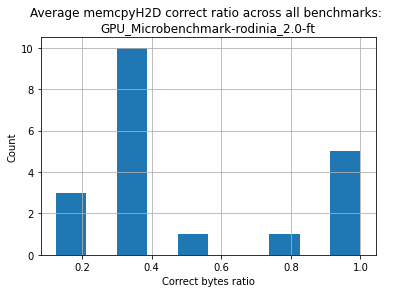

In [5]:
"""Get the correct bytes ratio for all benchmarks
"""
avg_ratios = []
for app_record in get_benchmark_app(benchmark_suites_list, trace_folder, benchmark_suites_table, root_logger):
    benchmark_suite_name = app_record["benchmark_suite_name"]
    app_name = app_record["app_name"]
    app_args_name = get_argfoldername(app_record["app_args"])

    try:
        app_specific_stat = mmio_stats[benchmark_suite_name][app_name][app_args_name]
        sst_stat = app_specific_stat["sst"]
        gpgpusim_stat = app_specific_stat["gpgpusim"]
        # print(sst_stat.keys())
        # print(gpgpusim_stat.keys())
        try:
            ratio_stat = sst_stat["cpu"]["correct_memD2H_ratio"]
            ratio_sum = ratio_stat["Sum.f64"]
            ratio_max = ratio_stat["Max.f64"]
            ratio_min = ratio_stat["Min.f64"]
            ratio_count = ratio_stat["Count.u64"]
            avg_ratio = ratio_sum / ratio_count
            avg_ratios.append(avg_ratio)
            print(f"{app_name}-{app_args_name} correct byte ratio: avg: {avg_ratio} max: {ratio_max} min: {ratio_min}")
        except KeyError:
            root_logger.warning(f"SST TestCPU memcpyD2H ratio stat for app: {app_name} in {benchmark_suite_name} with args: {app_args_name} does not exist!")
    except KeyError:
        root_logger.warning(f"Stats for app: {app_name} in {benchmark_suite_name} with args: {app_args_name} does not exist!")

fig, ax = plt.subplots()
ax.set_title("Average memcpyH2D correct ratio across all benchmarks: \n{}".format("-".join(benchmark_suites_list)))
ax.set_ylabel("Count")
ax.set_xlabel("Correct bytes ratio")
ax.grid(True)
ax.hist(avg_ratios)